In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/NVIDIA_Stock_Volatility_2014_2024.csv')
df.head()

,Date,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
0,2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
1,2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2,2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
3,2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
4,2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


In [4]:
df.shape

(2541, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2541 non-null   object 
 1   Close               2541 non-null   float64
 2   High                2541 non-null   float64
 3   Low                 2541 non-null   float64
 4   Open                2541 non-null   float64
 5   Volume              2541 non-null   int64  
 6   Daily_Return        2541 non-null   float64
 7   Rolling_Volatility  2541 non-null   float64
 8   ATR                 2541 non-null   float64
 9   Rolling_Mean        2541 non-null   float64
 10  Upper_Band          2541 non-null   float64
 11  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 238.3+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
Date,,,,,,,,,,,
2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


In [7]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Close                 0
High                  0
Low                   0
Open                  0
Volume                0
Daily_Return          0
Rolling_Volatility    0
ATR                   0
Rolling_Mean          0
Upper_Band            0
Lower_Band            0
dtype: int64


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df = df.sort_index()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2541 entries, 2014-01-31 to 2024-03-06
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               2541 non-null   float64
 1   High                2541 non-null   float64
 2   Low                 2541 non-null   float64
 3   Open                2541 non-null   float64
 4   Volume              2541 non-null   int64  
 5   Daily_Return        2541 non-null   float64
 6   Rolling_Volatility  2541 non-null   float64
 7   ATR                 2541 non-null   float64
 8   Rolling_Mean        2541 non-null   float64
 9   Upper_Band          2541 non-null   float64
 10  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 238.2 KB


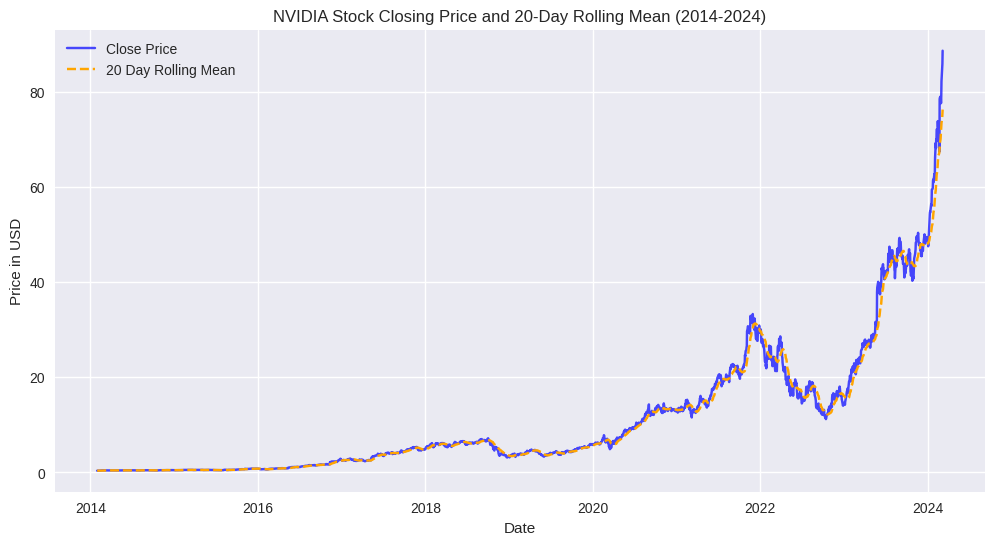

In [13]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df.index, df['Rolling_Mean'], label="20 Day Rolling Mean", color='orange', linestyle='--')
plt.title('NVIDIA Stock Closing Price and 20-Day Rolling Mean (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.show()

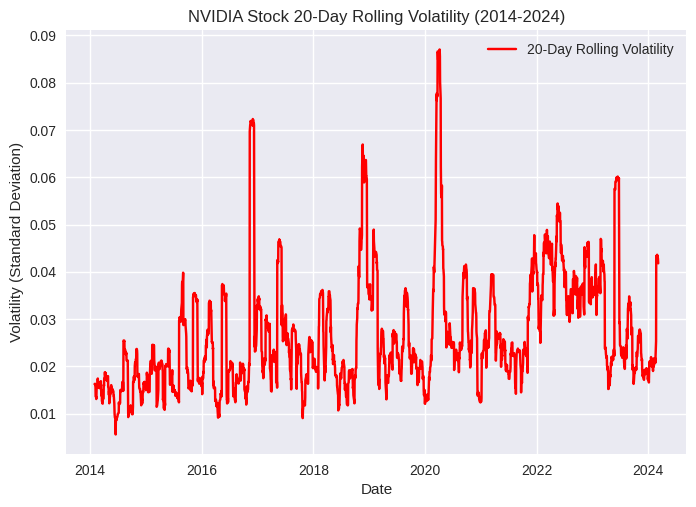

In [14]:
plt.plot(df.index, df['Rolling_Volatility'], label='20-Day Rolling Volatility', color='red')
plt.title('NVIDIA Stock 20-Day Rolling Volatility (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid(True)
plt.show()

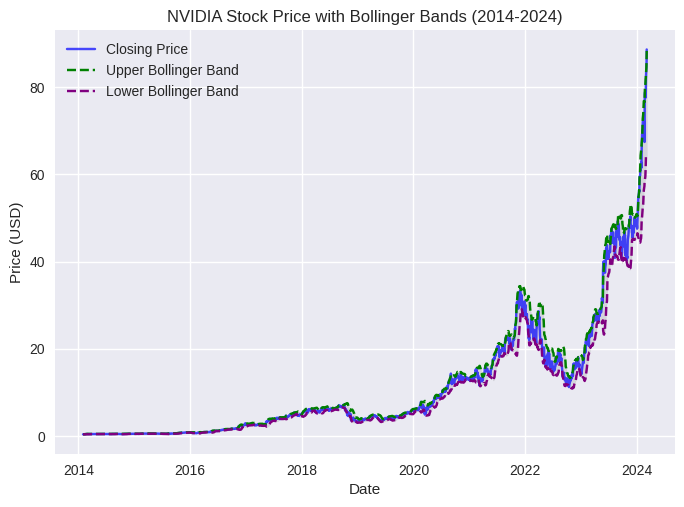

In [15]:
plt.plot(df.index, df['Close'], label='Closing Price', color='blue', alpha=0.7)
plt.plot(df.index, df['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(df.index, df['Lower_Band'], label='Lower Bollinger Band', color='purple', linestyle='--')
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.2)
plt.title('NVIDIA Stock Price with Bollinger Bands (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df['Volatility_Lag1'] = df['Rolling_Volatility'].shift(1)
df['Volatility_Lag5'] = df['Rolling_Volatility'].shift(5)
df['Return_Lag1'] = df['Daily_Return'].shift(1)

In [17]:
df.dropna(inplace=True)

In [18]:
result = adfuller(df['Rolling_Volatility'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] > 0.05:
    print("Series is non-stationary; consider differencing.")
    df['Volatility_Diff'] = df['Rolling_Volatility'].diff().dropna()
else:
    print("Series is stationary.")

ADF Statistic: -5.368057112795501
p-value: 3.951721154618162e-06
Critical Values: {'1%': np.float64(-3.4329569285480814), '5%': np.float64(-2.862691729403106), '10%': np.float64(-2.5673831097880595)}
Series is stationary.


In [19]:
scaler = MinMaxScaler()
features_to_scale = ['Rolling_Volatility', 'Volatility_Lag1', 'Volatility_Lag5', 'Return_Lag1', 'ATR', 'Volume']
df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]),
                         columns=features_to_scale, index=df.index)

In [20]:
df = df.drop(features_to_scale, axis=1).join(df_scaled)

In [21]:
print("\nUpdated Dataset Info:")
df.info()


Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2536 entries, 2014-02-07 to 2024-03-06
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               2536 non-null   float64
 1   High                2536 non-null   float64
 2   Low                 2536 non-null   float64
 3   Open                2536 non-null   float64
 4   Daily_Return        2536 non-null   float64
 5   Rolling_Mean        2536 non-null   float64
 6   Upper_Band          2536 non-null   float64
 7   Lower_Band          2536 non-null   float64
 8   Rolling_Volatility  2536 non-null   float64
 9   Volatility_Lag1     2536 non-null   float64
 10  Volatility_Lag5     2536 non-null   float64
 11  Return_Lag1         2536 non-null   float64
 12  ATR                 2536 non-null   float64
 13  Volume              2536 non-null   float64
dtypes: float64(14)
memory usage: 297.2 KB


In [22]:
train = df['Rolling_Volatility'][:'2022-12-31']
test = df['Rolling_Volatility']['2023-01-01':]

In [23]:
features = ['Rolling_Volatility', 'Volatility_Lag1', 'Volatility_Lag5', 'Return_Lag1', 'ATR', 'Volume']
X = df[features].values
y = df['Rolling_Volatility'].values

In [24]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)

In [25]:
train = df['Rolling_Volatility'][:'2022-12-31']
split_idx = len(train) - time_steps
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [26]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2231, 10, 6)
y_train shape: (2231,)
X_test shape: (295, 10, 6)
y_test shape: (295,)


In [27]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [28]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0319 - val_loss: 0.0044
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_

In [29]:
lstm_pred = lstm_model.predict(X_test)
print("lstm_pred shape:", lstm_pred.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
lstm_pred shape: (295, 1)


In [30]:
lstm_mse = mean_squared_error(y_test, lstm_pred)
print(f"LSTM MSE: {lstm_mse}")

LSTM MSE: 0.0019729739496124206


test_index_adjusted length: 295


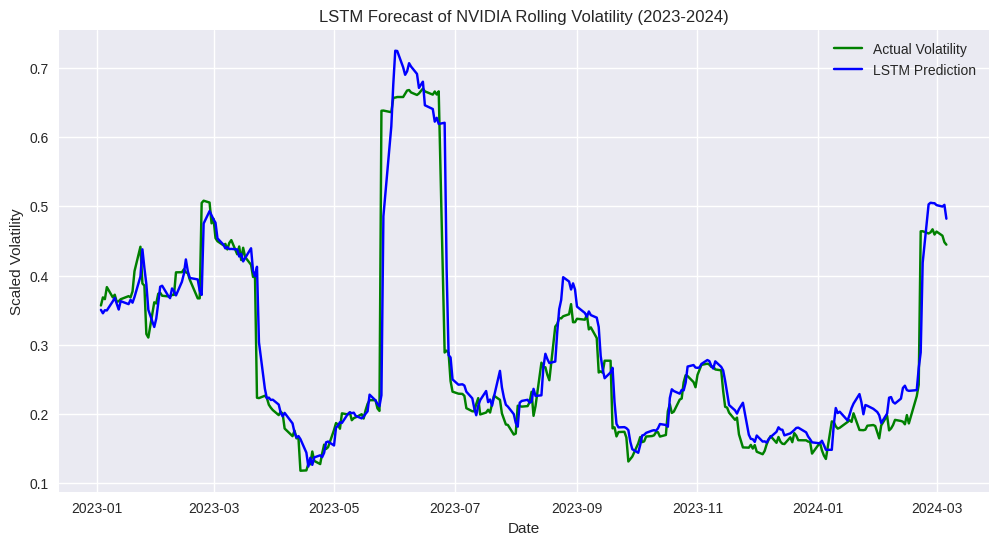

In [31]:
test_index_adjusted = df.index[split_idx + time_steps:split_idx + time_steps + len(y_test)]
print("test_index_adjusted length:", len(test_index_adjusted))

plt.figure(figsize=(12, 6))
plt.plot(test_index_adjusted, y_test, label='Actual Volatility', color='green')
plt.plot(test_index_adjusted, lstm_pred.flatten(), label='LSTM Prediction', color='blue')
plt.title('LSTM Forecast of NVIDIA Rolling Volatility (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Scaled Volatility')
plt.legend()
plt.grid(True)
plt.show()

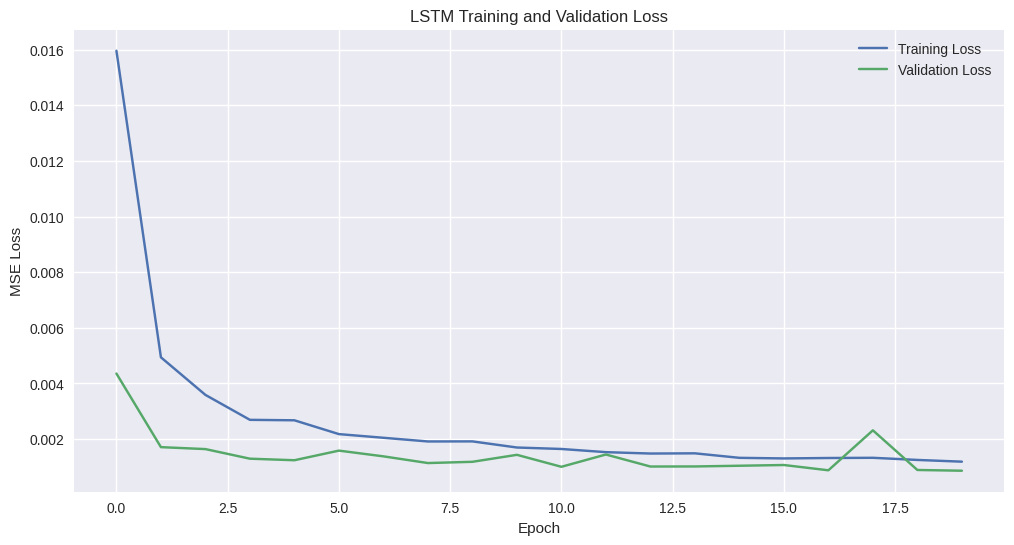

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()